## Unsupervised Learning Natural Language Processing Capstone 
In this unsupervised learning capstone, I used 10 novels from 5 authors from the NLTK Gutenberg corpus and [Project Gutenberg](https://www.gutenberg.org/) (which were manually added to the corpus). 


Steps and techniques:
-  Pick a set of texts. I used 10 different texts from different authors on Project Gutenberg.
-  Perform standard data cleaning on the text using things such as spacy and stopwords.
-  Break the data in to two groups, the training group (75%) and the holdout group(25%).
-  Perform various clustering methods, decide which technique best represents the data, and explain your reasoning.
-  Perform some unsupervised feature generation and selection using techniques such as Latent Semantics Analysis (LSA), tf-idf term-document matrix, word2vec packaging, Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF). 
-  Perform the clustering techniques on the holdout group and document the performance for changes, stability, and consistencies in comparison to the original model.
- Summarize all findings including visuals in a separate but linked document.
- Link to write-up: https://docs.google.com/document/d/1M7Ps1RfgudP8AfGlO6JXvav7QfrYjCdlIgjJgUDxfwY/edit?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import scipy
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re, os, sys
import requests
import pickle
import string
import en_core_web_sm
import urllib.request

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

#sklearn modules
import sklearn
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, AffinityPropagation 
from sklearn.datasets.samples_generator import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_score
import itertools
from itertools import cycle
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity


#nltk modules
import nltk
from nltk.corpus import gutenberg
from nltk.stem import WordNetLemmatizer 

In [2]:
books = pd.read_pickle("books.pkl")
books.head()

,book,author,sentence,genre
0,The Ivory Child,Henry Rider Haggard,the ivory child by henry rider haggard i allan...,Adventure
1,The Ivory Child,Henry Rider Haggard,amongst many other things it tells of the war ...,Adventure
2,The Ivory Child,Henry Rider Haggard,often since then i have wondered if this creat...,Adventure
3,The Ivory Child,Henry Rider Haggard,"it seems improbable, even impossible, but the ...",Adventure
4,The Ivory Child,Henry Rider Haggard,also he can form his opinion as to the religio...,Adventure


## Train, Test, and Holdout Groups

In [3]:
train_test, holdout= train_test_split(books, test_size=0.25, random_state=45)
train, test= train_test_split(train_test, test_size=0.30, random_state=45)

print('Train:', train.shape[0])
print('Test:', test.shape[0]) 
print('Holdout:', holdout.shape[0])

Train: 13307
Test: 5704
Holdout: 6338


## TF-IDF

In [4]:
vectorizer = TfidfVectorizer(max_df=0.6, min_df=2,
                            lowercase=True, use_idf=True,
                            norm='l2', stop_words='english',
                            smooth_idf=True)

# Applying the vectorizer to sentence
TfIdf = vectorizer.fit_transform(train['sentence'])


## LSA

The percentage of total variance in the dataset explained by each component from LSA.
 [0.00404921 0.00297699 0.0030513  0.00286105 0.00270565]
Percent variance captured by all components: 22.838393152088297


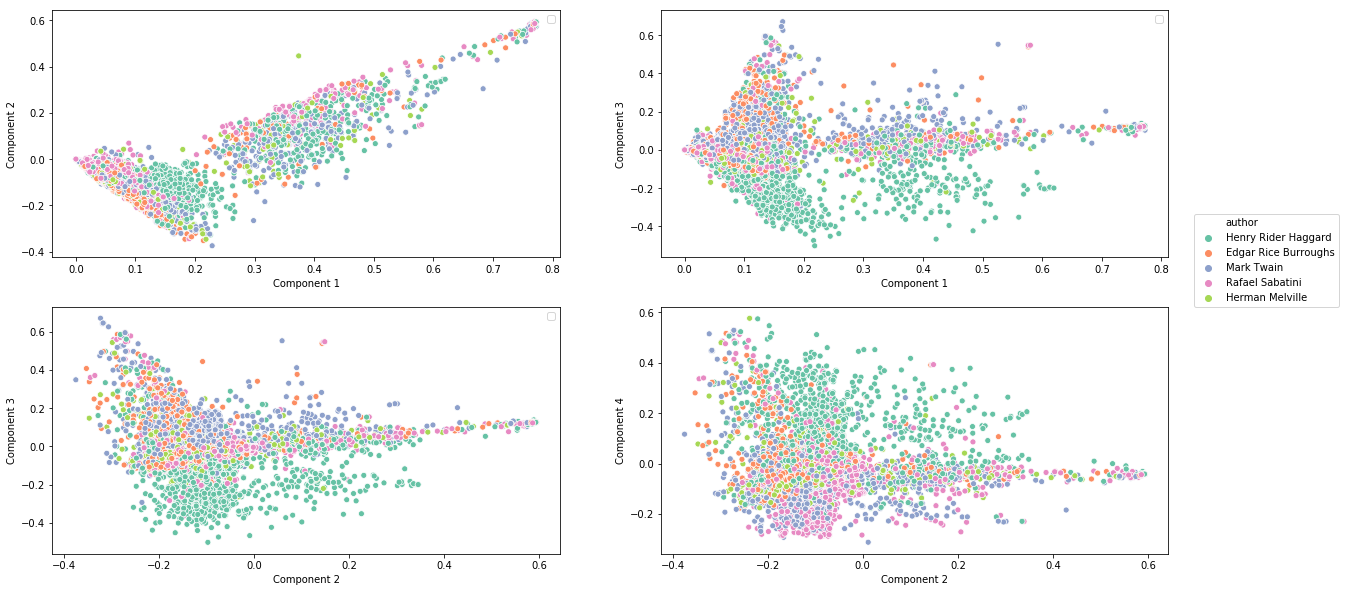

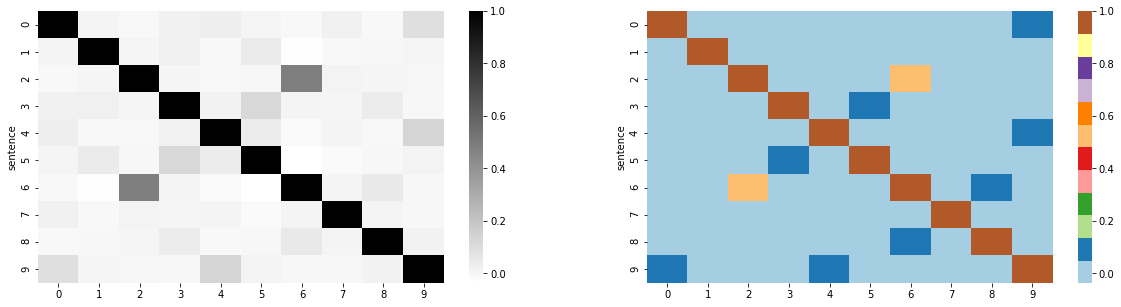

Key:
0 still, each seeks honour after his own manner, so seek thou as thou wilt; but thou shalt find bitterness and empty days, and thy plots shall come back on thine own head yes, even though they bring gudruda and me to sorrow and death
1 the three turned to see the figure of ko-tan emerging from the foliage
2 i'll put you up a snack to eat
3 de lesdiguieres accounted himself an imposing personality, and he had every reason to do so, for in his time he had seen many a poor devil scared out of all his senses by the thunder of his voice
4 in the end she gave way under the pressure of these men wills, and did so with the best grace she could summon, resolved to drive from her heart and mind the one real obstacle of which, for very shame, she had made no mention to sir john
5 here we found ourselves facing the same cold, cruel tribunal
6 if you stay here botherin' around me for about a half a minute longer you'll get something you won't want
7 that is what we are going to change
8 well, 

In [8]:
#Our SVD data reducer. Features are reduced down to 250.
svd = TruncatedSVD(200, random_state=45)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
LSA = lsa.fit_transform(TfIdf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print(
    'The percentage of total variance in the dataset explained by each',
    'component from LSA.\n',
    variance_explained[:5]
)
print("Percent variance captured by all components:",total_variance*100)

# Compare the sklearn solution to ours 

plt.figure(figsize=(20,10))
for i, c in enumerate([(0,1), (0,2), (1,2), (1,3)]): 
    plt.subplot(2,2,i+1)
    sns.scatterplot(x=LSA[:, c[0]], y=LSA[:, c[1]], hue=train['author'],
                    palette="Set2")
    plt.legend('')
    plt.xlabel('Component ' + str(c[0]+1))
    plt.ylabel('Component ' + str(c[1]+1))
plt.legend(loc = (1.05, 1))
plt.show()



# Compute document similarity using LSA component
similarity = cosine_similarity(LSA)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=train['sentence']).iloc[0:10,0:10]
#Making a plot
plt.figure(figsize=(20,5))
plt.subplot(121)
ax = sns.heatmap(sim_matrix,yticklabels=range(10), cmap='binary')
plt.subplot(122)
ax = sns.heatmap(sim_matrix,yticklabels=range(10), cmap='Paired')
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

In [9]:
# Transform test set 
test_tfidf = vectorizer.transform(test['sentence'])
LSA_test = lsa.transform(test_tfidf)

# model vars
x_train = LSA
x_test = LSA_test
y_train = train['author']
y_test = test['author']

## Supervised Learning

### Logistic Regression

In [21]:
lr = LogisticRegression(C=10000, n_jobs=2, multi_class='ovr',
                        solver='newton-cg',random_state=45)
lr.fit(x_train, y_train)
print('cross-validation:', cross_val_score(lr, x_train, y_train, cv=5))
print('Training set score:', lr.score(x_train, y_train))
print('Test set score:', lr.score(x_test, y_test))
pd.crosstab(y_test, lr.predict(x_test))



cross-validation: [0.66929429 0.68306421 0.69222097 0.68120301 0.66716811]
Training set score: 0.7017359284587059
Test set score: 0.6746143057503506


col_0,Edgar Rice Burroughs,Henry Rider Haggard,Herman Melville,Mark Twain,Rafael Sabatini
author,,,,,
Edgar Rice Burroughs,733,63,63,76,92
Henry Rider Haggard,80,784,68,84,133
Herman Melville,87,78,447,68,138
Mark Twain,67,73,55,926,160
Rafael Sabatini,114,148,104,105,958


In [9]:

rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, 
                                      max_features='auto',random_state=45)
rfc.fit(x_train, y_train)

print('cross-validation:', cross_val_score(rfc, x_train, y_train, cv=5))
print('Training set score:', rfc.score(x_train, y_train))
print('Test set score:', rfc.score(x_test, y_test))



cross-validation: [0.58033033 0.59331581 0.59113115 0.59774436 0.58969537]
Training set score: 0.7951454121890734
Test set score: 0.5864305750350631


### Pickling

In [ ]:
# train.to_pickle('train.pkl')
# test.to_pickle('test.pkl')
# holdout.to_pickle('holdout.pkl')

In [ ]:
# TfIdf.to_pickle('TfIdf.pkl')

## Unsupervised Learning Methods

### K-Means

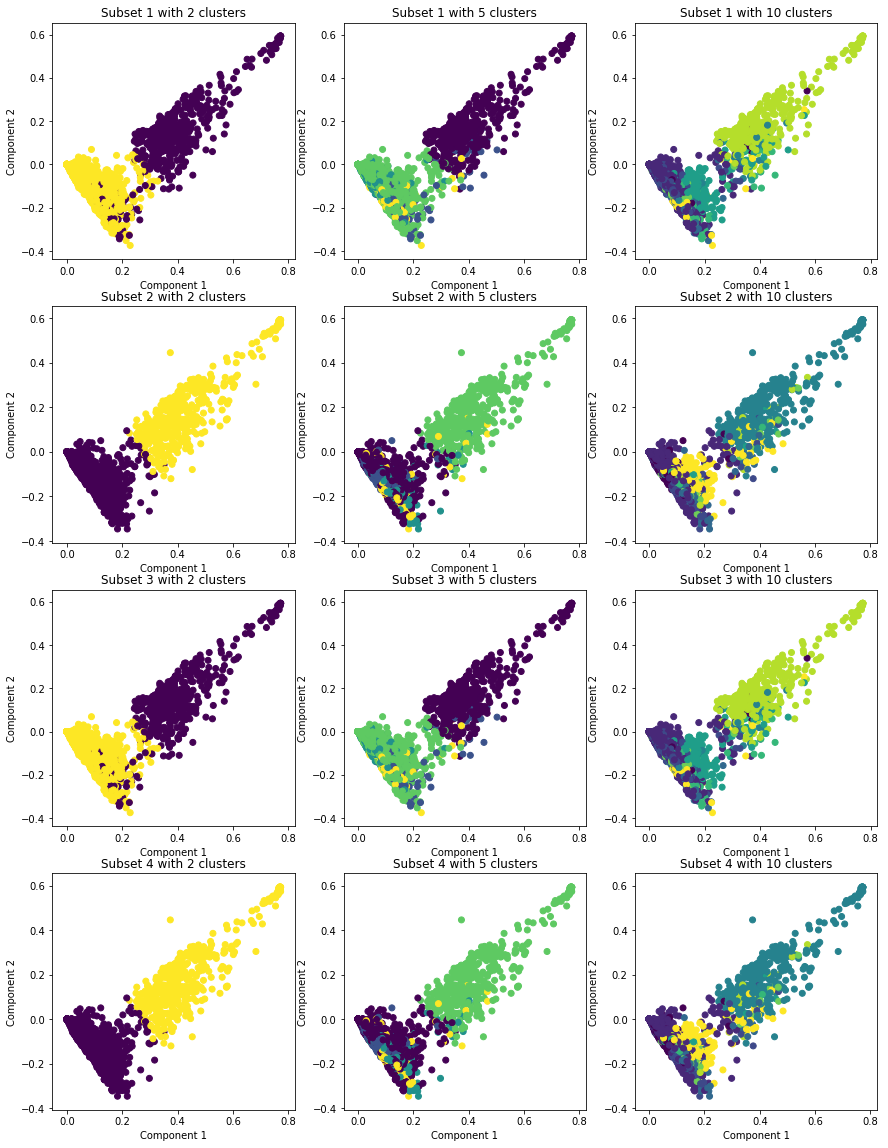

In [22]:
# Split the data to test for consistent clustering
lsa1, lsa3= train_test_split(LSA, test_size=0.50, random_state=45)
lsa1, lsa2= train_test_split(LSA, test_size=0.50, random_state=45)
lsa3, lsa4= train_test_split(LSA, test_size=0.50, random_state=45)

plt.figure(figsize=(20,20))
# Calculate predicted values.
preds = {}
models = {}
clusters = (2,5,10)

for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them for clusters 2 to 10.
    for col, nclust in  enumerate(clusters):
        models[row, nclust] = KMeans(n_clusters=nclust, random_state=42).fit(data)
        preds[row, nclust] = models[row, nclust].predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        

In [23]:
# Function to evaluate the clustering
def cluster_eval(clusters, preds, models, n):
    for i in clusters: 
        pred = preds[4,i]
        model = models[4,i]
        labels = model.labels_
        print('Adjusted Rand index for', i, 'clusters:', 
              round(metrics.adjusted_rand_score(train['author'], pred),5))
        print('The silhouette coefficient for %d clusters: %.4f \n' % (i, metrics.silhouette_score(LSA, labels, metric='euclidean')))

    return(pd.crosstab(train['author'], preds[4,n]).T)

cluster_eval(clusters, preds, models, 5)

Adjusted Rand index for 2 clusters: 0.00022
The silhouette coefficient for 2 clusters: 0.0144 

Adjusted Rand index for 5 clusters: 0.00756
The silhouette coefficient for 5 clusters: 0.0205 

Adjusted Rand index for 10 clusters: 0.02926
The silhouette coefficient for 10 clusters: 0.0318 



author,Edgar Rice Burroughs,Henry Rider Haggard,Herman Melville,Mark Twain,Rafael Sabatini
col_0,,,,,
0,99,98,56,72,68
1,168,101,73,91,99
2,63,278,68,206,184
3,2087,1777,1564,2459,2820
4,87,334,171,153,131


### Agglomerative clustering

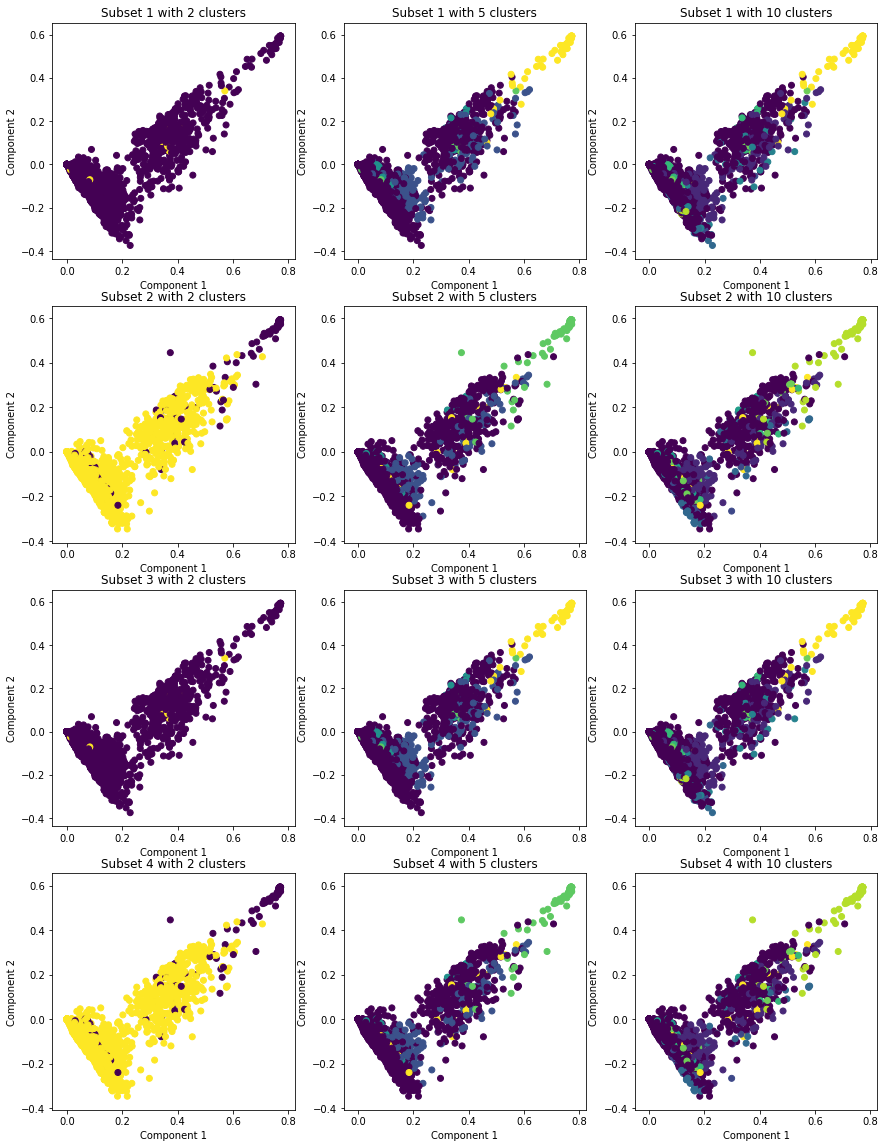

In [24]:
plt.figure(figsize=(20,20))
# Calculate predicted values.
preds_2 = {}
models_2 = {}
clusters = (2,5,10)
for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for col, nclust in  enumerate(clusters):
        models_2[row, nclust] = AgglomerativeClustering(n_clusters=nclust).fit(data)
        preds_2[row, nclust] = AgglomerativeClustering(n_clusters=nclust).fit_predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds_2[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        
plt.show()

In [25]:
cluster_eval(clusters, preds_2, models_2, 5)

Adjusted Rand index for 2 clusters: -0.00212
The silhouette coefficient for 2 clusters: 0.0115 

Adjusted Rand index for 5 clusters: -0.00205
The silhouette coefficient for 5 clusters: 0.0073 

Adjusted Rand index for 10 clusters: 0.00547
The silhouette coefficient for 10 clusters: 0.0068 



author,Edgar Rice Burroughs,Henry Rider Haggard,Herman Melville,Mark Twain,Rafael Sabatini
col_0,,,,,
0,2491,2326,1908,2943,2912
1,1,238,12,3,27
2,0,0,0,0,141
3,0,4,6,4,184
4,12,20,6,31,38


## Holdout Group

### Logistic Regression

In [26]:
holdout_tfidf = vectorizer.transform(holdout['sentence'])
LSA_holdout = lsa.transform(holdout_tfidf)

# model vars
x_holdout = LSA_holdout
y_holdout = holdout['author']

print('Holdout set score:', lr.score(x_holdout, y_holdout))
print('Test set score from earlier:', lr.score(x_test, y_test))
pd.crosstab(y_holdout, lr.predict(x_holdout))

Holdout set score: 0.6804985799936889
Test set score from earlier: 0.6746143057503506


col_0,Edgar Rice Burroughs,Henry Rider Haggard,Herman Melville,Mark Twain,Rafael Sabatini
author,,,,,
Edgar Rice Burroughs,884,70,79,75,111
Henry Rider Haggard,105,796,78,98,157
Herman Melville,106,90,466,117,164
Mark Twain,66,63,46,1118,142
Rafael Sabatini,110,131,102,115,1049


### K-Means

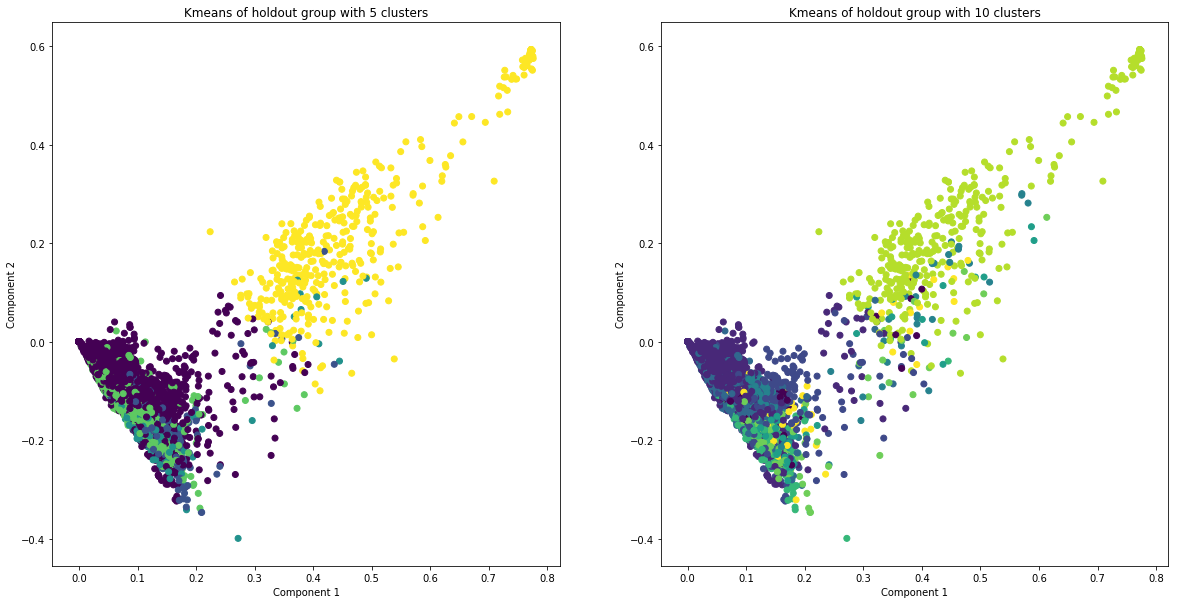

In [27]:
plt.figure(figsize=(20,10))

plt.subplot(121)
hpreds5 = KMeans(n_clusters=5, random_state=45).fit_predict(LSA_holdout)
plt.scatter(LSA_holdout[:, 0], LSA_holdout[:, 1], c=hpreds5)
plt.title('Kmeans of holdout group with 5 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.subplot(122)
hpreds10 = KMeans(n_clusters=10, random_state=45).fit_predict(LSA_holdout)
plt.scatter(LSA_holdout[:, 0], LSA_holdout[:, 1], c=hpreds10)
plt.title('Kmeans of holdout group with 10 clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
        
plt.show()

In [28]:
print("Holdout Silhouette w 5 clusters", silhouette_score(x_holdout, hpreds5))
print("\n")
print("Holdout Silhouette w 10 clusters", silhouette_score(x_holdout, hpreds10))


Holdout Silhouette w 5 clusters 0.023042668376548132


Holdout Silhouette w 10 clusters 0.03637194011791407
